Running variant=logic, regime=trend, lr=0.01
  [Init] lin_short w[0:3]: [0.019999999552965164, 0.019999999552965164, 0.019999999552965164]
         tau1, tau2: 0.026598559692502022 -0.0030449682381004095
  [Info] No trainable params—skipping training loop for logic‐only variant.
  [Final] lin_short w[0:3]: [0.019999999552965164, 0.019999999552965164, 0.019999999552965164]
         tau1, tau2: 0.026598559692502022 -0.0030449682381004095


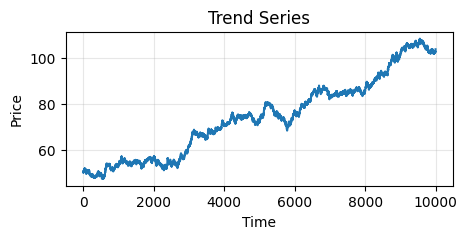

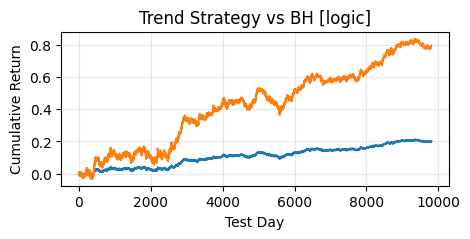

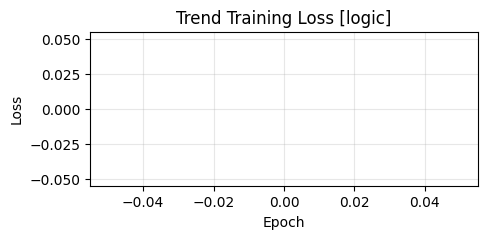

Running variant=logic, regime=switch, lr=0.001
  [Init] lin_short w[0:3]: [0.019999999552965164, 0.019999999552965164, 0.019999999552965164]
         tau1, tau2: 0.026598559692502022 -0.0030449682381004095
  [Info] No trainable params—skipping training loop for logic‐only variant.
  [Final] lin_short w[0:3]: [0.019999999552965164, 0.019999999552965164, 0.019999999552965164]
         tau1, tau2: 0.026598559692502022 -0.0030449682381004095


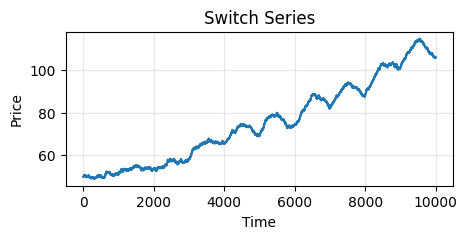

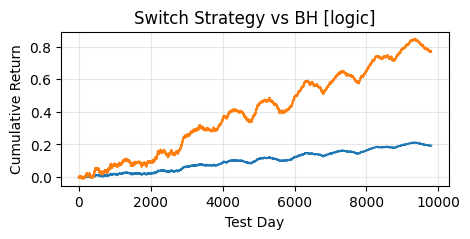

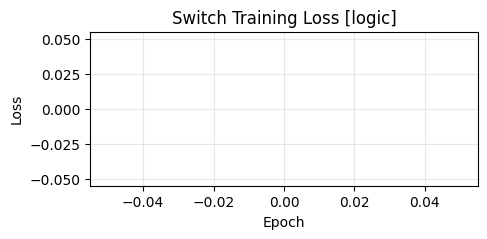

Running variant=logic, regime=flat, lr=0.01
  [Init] lin_short w[0:3]: [0.019999999552965164, 0.019999999552965164, 0.019999999552965164]
         tau1, tau2: 0.026598559692502022 -0.0030449682381004095
  [Info] No trainable params—skipping training loop for logic‐only variant.
  [Final] lin_short w[0:3]: [0.019999999552965164, 0.019999999552965164, 0.019999999552965164]
         tau1, tau2: 0.026598559692502022 -0.0030449682381004095


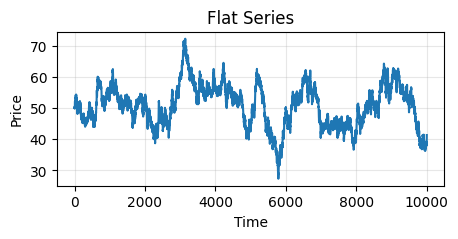

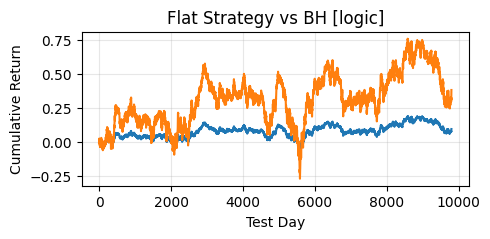

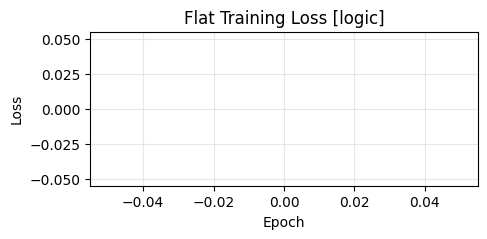

Running variant=logic+feature, regime=trend, lr=0.01
  [Init] lin_short w[0:3]: [0.019999999552965164, 0.019999999552965164, 0.019999999552965164]
         tau1, tau2: -0.03434772044420242 -0.019891293719410896
  [Final] lin_short w[0:3]: [0.019999999552965164, 0.019999999552965164, 0.019999999552965164]
         tau1, tau2: -0.03434772044420242 3.0133023262023926


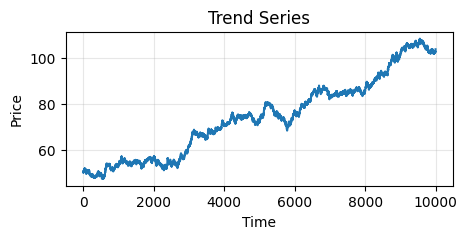

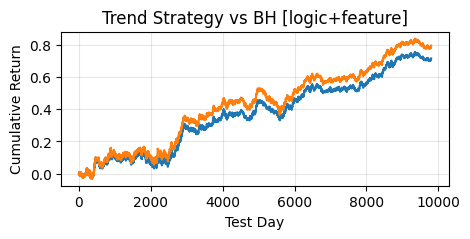

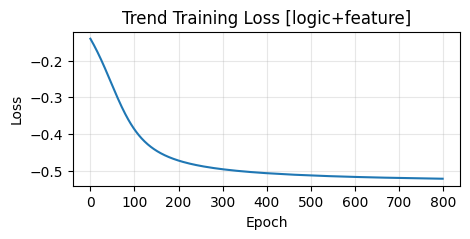

Running variant=logic+feature, regime=switch, lr=0.001
  [Init] lin_short w[0:3]: [0.019999999552965164, 0.019999999552965164, 0.019999999552965164]
         tau1, tau2: -0.03434772044420242 -0.019891293719410896
  [Final] lin_short w[0:3]: [0.019999999552965164, 0.019999999552965164, 0.019999999552965164]
         tau1, tau2: -0.03434772044420242 2.92391037940979


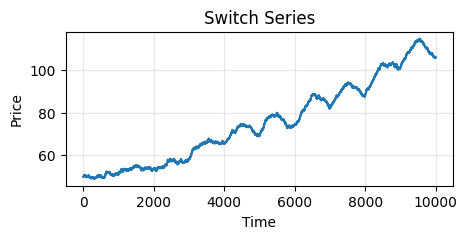

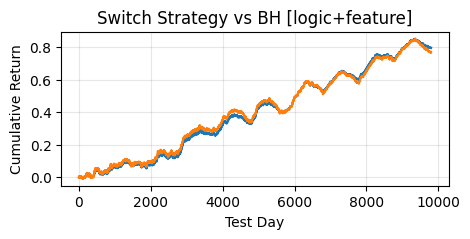

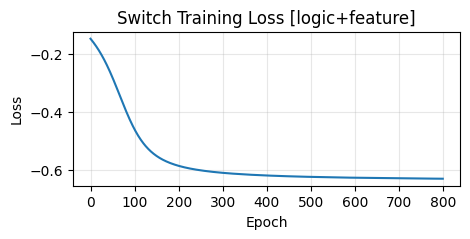

Running variant=logic+feature, regime=flat, lr=0.01
  [Init] lin_short w[0:3]: [0.019999999552965164, 0.019999999552965164, 0.019999999552965164]
         tau1, tau2: -0.03434772044420242 -0.019891293719410896
  [Final] lin_short w[0:3]: [0.019999999552965164, 0.019999999552965164, 0.019999999552965164]
         tau1, tau2: -0.03434772044420242 0.4572656750679016


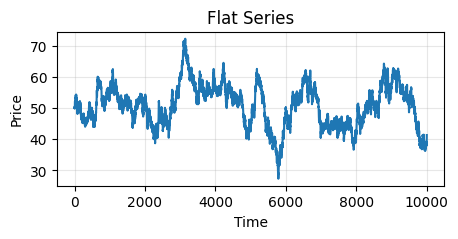

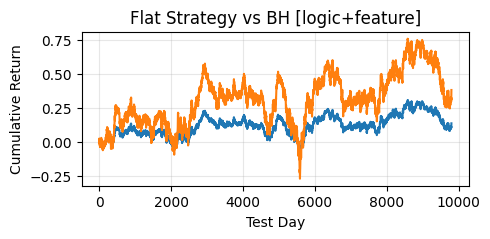

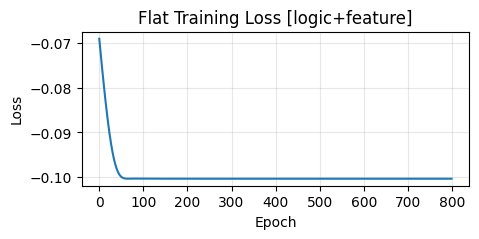

Running variant=all, regime=trend, lr=0.01
  [Init] lin_short w[0:3]: [0.07004065811634064, -0.04892846569418907, -0.03349074348807335]
         tau1, tau2: 0.005390087142586708 0.13589279353618622
  [Final] lin_short w[0:3]: [0.07004065811634064, -0.04892846569418907, -0.03349074348807335]
         tau1, tau2: 0.005390087142586708 3.752211093902588


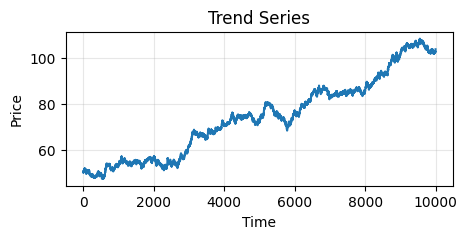

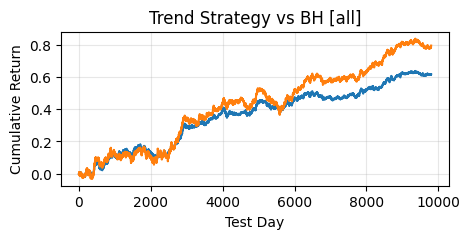

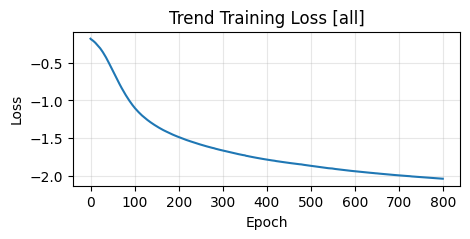

Running variant=all, regime=switch, lr=0.001
  [Init] lin_short w[0:3]: [0.07004065811634064, -0.04892846569418907, -0.03349074348807335]
         tau1, tau2: 0.005390087142586708 0.13589279353618622
  [Final] lin_short w[0:3]: [0.07004065811634064, -0.04892846569418907, -0.03349074348807335]
         tau1, tau2: 0.005390087142586708 3.664905309677124


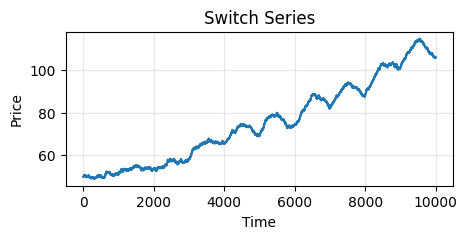

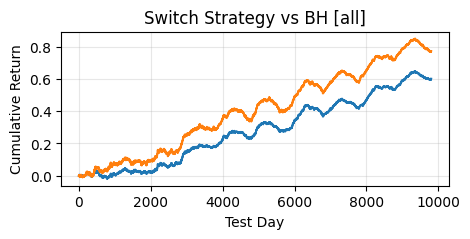

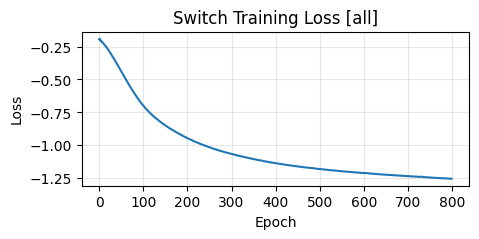

Running variant=all, regime=flat, lr=0.01
  [Init] lin_short w[0:3]: [0.07004065811634064, -0.04892846569418907, -0.03349074348807335]
         tau1, tau2: 0.005390087142586708 0.13589279353618622
  [Final] lin_short w[0:3]: [0.07004065811634064, -0.04892846569418907, -0.03349074348807335]
         tau1, tau2: 0.005390087142586708 4.025902271270752


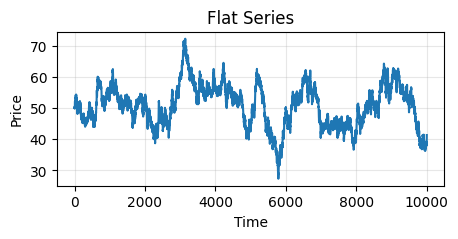

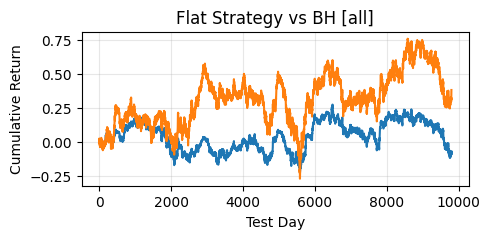

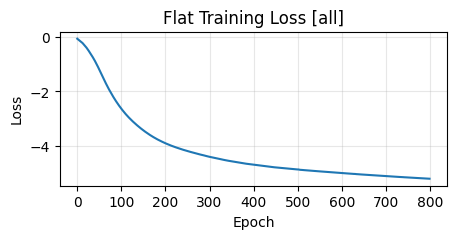

Variant,all,logic,logic+feature
Regime,,,
flat,-0.019579,0.061050,0.053888
switch,0.895438,0.861095,0.994790
trend,0.506092,0.446765,0.445523


In [1]:
import pandas as pd
from evaluate import evaluate_synthetic

# Hyperparams
window_long, window_short = 200, 50
variants  = ['logic','logic+feature','all']
regimes   = ['trend','switch','flat']
beta      = 10.0
epochs    = 800

results = []
for variant in variants:
    for regime in regimes:
        lr = 0.001 if regime=='switch' else 0.01
        print(f"Running variant={variant}, regime={regime}, lr={lr}")
        sr = evaluate_synthetic(
            regime=regime,
            window_short=window_short,
            window_long=window_long,
            variant=variant,
            beta=beta,
            lr=lr,
            epochs=epochs
        )
        results.append((variant, regime, sr))

# Build and display the test‐Sharpe table
df = pd.DataFrame(results, columns=['Variant','Regime','Sharpe']) \
       .pivot(index='Regime', columns='Variant', values='Sharpe')
display(df)
